# UFO sightings analysis

## Research tasks: 
-  Find patterns in distribution of UFO sightings in USA
-  Find relations between UFO sightings and weather conditions

## Used datasets: 
-  UFO sightings. Contains coordinates, timestamp and brief description 
-  US cities coordinates
-  Weather archive. Contains worldwide daily measures with related weather station codes.
-  Weather stations metadata. Contains station codes and coordinates.

In [ ]:
import pandas as pd
import json
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree.tree import DecisionTreeClassifier
from scipy import stats
from IPython.display import Image
import sklearn.tree
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import math
import os.path
import sys
import folium
import folium.features

%matplotlib inline
sns.set_style("whitegrid")
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5})


## Find patterns in distribution of UFO sightings in USA

### Step 1. Acquire data

In [ ]:
#Used UFO sightings dataset from https://www.kaggle.com/NUFORC/ufo-sightings
data = pd.read_csv("scrubbed.csv", low_memory=False)
data.head()

In [ ]:
#Used cities data from https://simplemaps.com/data/us-cities
cities_data = pd.read_csv("uscitiesv1.3.csv")

#selects cities with population over 50000
large_cities = cities_data[cities_data["population"]>50000]
large_cities.set_index("city", inplace=True)
large_cities.head()

### Step2. Data preparation

In [ ]:
# UFO sightings dataset contains shape of object
print(data["shape"].unique())

In [ ]:
#We select knowingly non-technogenic objects, that not like aircrafts
selectedshapes = ["circle", "sphere", "flash", "light", "fireball", "oval", "formation", "other", "egg", "changing", "cross"]

In [ ]:
#Parse datetime and numeric attributes with mistakes
data["dt"] = pd.to_datetime(data["datetime"], format="%m/%d/%Y %H:%M", errors="coerce")
data["lat"] = pd.to_numeric(data["latitude"], errors="coerce")
data["long"] = pd.to_numeric(data["longitude "], errors="coerce")

#Select only US data for required shape and period
condition1 = data['country']=="us" 
condition2 = data["shape"].isin(selectedshapes)
condition3 = data["dt"].dt.year>=2010

data.dropna(inplace=True, axis=0)
data = data[condition1 & condition2 & condition3]

#Select only required attributes
features = ["dt", "shape", "comments", "lat", "long"]
selected = data.loc[:,features]

In [35]:
selected.head()

,dt,shape,comments,lat,long
212,2010-10-10 01:00:00,light,Xmas colored rotating lights. ((NUFORC Note: ...,42.767500,-78.744167
213,2010-10-10 02:30:00,circle,possible UFO sighting,40.273611,-76.884722
214,2010-10-10 03:00:00,circle,2 objects blinking red and white&#44 disappear...,41.593056,-81.526944
215,2010-10-10 08:30:00,formation,Strange orange lights in the night sky,34.376944,-82.695833
216,2010-10-10 12:00:00,light,&quot;Star&quot; like objects during clear day...,41.026389,-73.628889


In [36]:
#Show part of dataset as markers on map with popups. We can't show all data because of Folium limitations. 
#We can check that usage of cluster analysis is useful.
m = folium.Map(zoom_start=6,  tiles="OpenStreetMap", location=[36.174465, -86.767960])
sample = selected.sample(frac=0.1)
for i in range(0,len(sample), 5):
    row = sample.iloc[i]
    p = "{}; {}; {}".format(row["comments"], str(row["dt"]), row["shape"])
    folium.Marker(location=[row["lat"], row["long"]], popup=p).add_to(m)
m

In [37]:
#Get data for cluster analysis
clusteringfeatures=["lat", "long"]
clusteringdata=selected.loc[:,clusteringfeatures]
clusteringdata.head()

,lat,long
212,42.767500,-78.744167
213,40.273611,-76.884722
214,41.593056,-81.526944
215,34.376944,-82.695833
216,41.026389,-73.628889


### Step 3. Data analysis

In [38]:
# Normalize data
scaler = StandardScaler()
transformed_data = scaler.fit_transform(clusteringdata)


In [39]:
#Do clusterisation by K-mean for different k (2-30). Store for each k model and error.|
clustering_models = dict()
clustering_errors = dict()
for k in range(2,30):
    kmeans = KMeans(n_clusters=k, random_state=0)
    model = kmeans.fit(transformed_data)
    clustering_models[k] = model
    clustering_errors[k] = math.sqrt(model.inertia_)

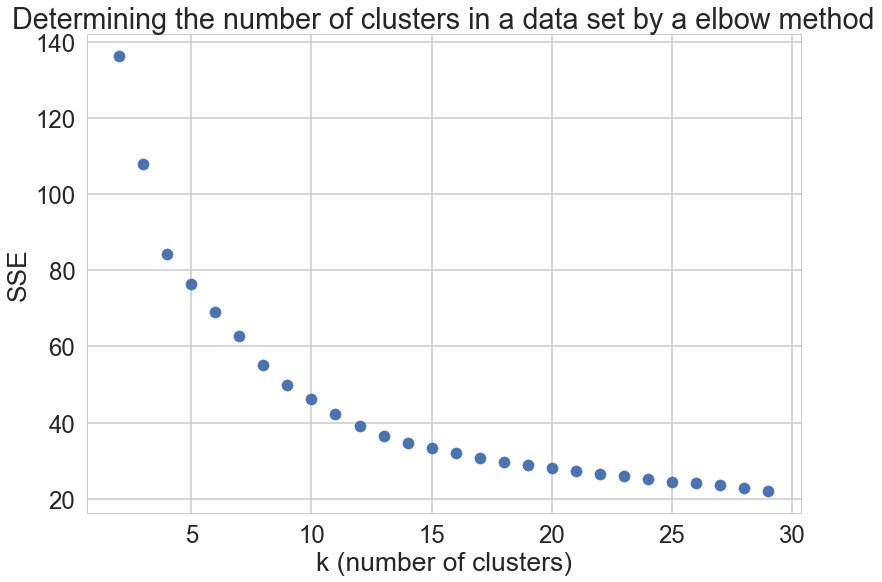

In [40]:
#Show error vs k and select best k.
plt.scatter(x=[x for x in clustering_errors], y=[clustering_errors[y] for y in clustering_errors])
plt.title("Determining the number of clusters in a data set by a elbow method")
plt.xlabel("k (number of clusters)")
plt.ylabel("SSE")
plt.show()

In [41]:
selected_k = 15
selected_model = clustering_models[selected_k]

In [42]:
#merge cluster centers and main dataset
cluster_centers = pd.DataFrame(scaler.inverse_transform(selected_model.cluster_centers_),
                               columns=["cluster_lat", "cluster_long"])
cluster_centers["cluster"] = range(0, len(cluster_centers))
selected["cluster"] = selected_model.labels_
selected = pd.merge(selected, cluster_centers, how="inner", on="cluster")
selected.head()

,dt,shape,comments,lat,long,cluster,cluster_lat,cluster_long
0,2010-10-10 01:00:00,light,Xmas colored rotating lights. ((NUFORC Note: ...,42.767500,-78.744167,11,42.652549,-72.966838
1,2010-10-10 17:10:00,light,Saw a light in the sky fading in and out over ...,41.166944,-73.205278,11,42.652549,-72.966838
2,2010-10-10 20:20:00,fireball,Bus sized fireball object over 91 about 3-400 ...,41.852500,-72.644167,11,42.652549,-72.966838
3,2010-10-10 21:30:00,circle,Circle of light SUNY Albany.,42.652500,-73.756667,11,42.652549,-72.966838
4,2011-10-10 10:30:00,circle,Amber object in night sky during full moon&#44...,42.096389,-79.375833,11,42.652549,-72.966838


### Step 4. Visualization

In [43]:
#Function for calculate distance on earth between two locations given by latitude and longitude
def haversine(lat1, lon1, lat2, lon2):
    R = 6378.137 #Earth radius in km
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) \
        * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    return d * 1000

In [44]:
#Append to dataset distances between location of sighting and cluster center
selected["distance"] = selected.apply(lambda x: haversine(x["lat"], x["long"], x["cluster_lat"], x["cluster_long"]), axis=1)

#Calculate cluster confidence circle for cluster visualization on map
cluster_radius = pd.DataFrame(selected.groupby("cluster").std()["distance"] * 2.326)
cluster_radius['cluster'] = cluster_radius.index
cluster_centers = pd.merge(cluster_centers, cluster_radius, how="inner", on="cluster")

In [45]:
#Function to convert color from RGBA tuple to string format usable with HTML (like #345466)
def rgb_to_hex(color):
    return "#{0:02x}{1:02x}{2:02x}".format(int(color[0]*255), int(color[1]*255), int(color[2]*255))

In [46]:
#Function for clusters visualization
def getclusteredmap():
    m = folium.Map(zoom_start=4,  tiles="OpenStreetMap", location=[39.007504, -94.529625])
    n = len(cluster_centers)
    maxcluster = cluster_centers["cluster"].max()
    
    #Visualize clusters as confidence circles
    for i in range(0,n):
        row= cluster_centers.iloc[i]
        c = rgb_to_hex(cm.brg(float(row["cluster"])/maxcluster))
        r = cluster_radius.loc[row["cluster"]]["distance"]
        folium.Circle(location=[row["cluster_lat"], row["cluster_long"]],  radius=r, color=c).add_to(m)
    
    #Visualize each 1 of 10 sighting for 
    for i in range(0,len(selected), 10):
        row = selected.iloc[i]
        c = rgb_to_hex(cm.brg(float(row["cluster"])/maxcluster))
        folium.CircleMarker(location=[row["lat"], row["long"]], radius=1.5, color=c).add_to(m)
    return m

In [47]:
getclusteredmap()

In [48]:
# Function for selection of cities closest to cluster centers
def find_closest_city(lat, long):

    #Due to low calculation speed we narrow square of finding closest city. This gives obout 100x speedup
    c1 = large_cities["lat"]< (lat + 2)
    c2 = large_cities["lat"]> (lat - 2)
    c3 = large_cities["lng"]> (long - 2)
    c4 = large_cities["lng"]< (long + 2)
    partial = large_cities[c1 & c2 & c3 & c4]                           
    
    if len(partial)>0:
        return partial.apply(lambda x: (math.pow(lat - x["lat"], 2) + math.pow(long - x["lng"],2)), axis=1).idxmin()
    else:
        return large_cities.apply(lambda x: (math.pow(lat - x["lat"], 2) + math.pow(long - x["lng"],2)), axis=1).idxmin()

cluster_centers["closest_city"]=cluster_centers.apply(lambda x: (find_closest_city( x["cluster_lat"], x["cluster_long"])), axis=1)

# We got cities wich closest to cluster centers
cluster_centers.loc[:,["closest_city"]]


,closest_city
0,Lake Havasu City
1,Lancaster
2,Yakima
3,Beaumont
4,Woodbury
5,Daly City
6,Grand Junction
7,Anchorage
8,McKinney
9,Gary


In [49]:
# Find city that closest to each UFO sighting
selected["closest_city"]=selected.apply(lambda x: (find_closest_city( x["lat"], x["long"])), axis=1)

# Group data and find top 10 cities for number of sightings
cities = selected.groupby("closest_city").count().iloc[:,3].sort_values(ascending = False)[:10]
cities


closest_city
Wilmington     281
Portland       273
Pittsburgh     191
Springfield    147
Lakewood       144
Seattle        141
Columbus       135
Columbia       118
Lancaster      111
Saint Louis    110
Name: lat, dtype: int64

In [50]:
# Function for visualization cities on map. Used map tiles without text. Radius of marker proportional to count of sightings
def getcirclemap():
    m = folium.Map(zoom_start=6,  tiles="stamenwatercolor", location=[40.440624, -76.995888])
    
    for i in range(0,10):
        row= large_cities.loc[large_cities.index== cities.index[i]].iloc[0,:]
        r = int(cities[i])/20
        location=[row["lat"], row["lng"]]
        folium.CircleMarker(location,  radius=r, color='#ff2f2f', fill_color='#ff2f2f', fill=True, fill_opacity=0.8).add_to(m)
        folium.Marker(location=location, icon=folium.DivIcon(icon_size=(150,36), icon_anchor=(40,0),html='<div style="font-size: {}pt">{}</div>'.format(int(r+5),cities.index[i]))).add_to(m)
    return m
getcirclemap()

## Find relations between UFO sightings and weather conditions

### Steps 1 and 2. Acquire and prepare additional data (weather dataset)

In [ ]:
# Dataset from https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/
# Due to RAM limitations we use chunked csv reading

for year in range(2010:2015): 
    #Filter by country
    weather_iterator = pd.read_csv("{0}.csv".format(year), iterator=True, chunksize=10000, header=None, 
                                   names=['id','date','parameter','value', 'm', 'q', 's', 'time'])
    wd = pd.concat([chunk[chunk['id'].str.startswith("US")] for chunk in weather_iterator])
    wd.loc[:,"id":"value"].to_csv("us{0}.csv".format(year), index=False)

    #Select only stations with known temperature
    weather_iterator = pd.read_csv("us{0}.csv".format(year), iterator=True, chunksize=10000)
    wd = pd.concat([chunk[chunk['parameter']=="TMAX"] for chunk in weather_iterator])
    pd.DataFrame(wd["id"].unique()).to_csv("stations_with_t{0}}.csv".format(year), index = False)

    #Clean sources for stations with t
    ids = pd.read_csv("stations_with_t{0}.csv".format(year))
    weather_iterator = pd.read_csv("us{0}.csv".format(year), iterator=True, chunksize=10000)
    wd = pd.concat([chunk[chunk['id'].isin(ids["0"])] for chunk in weather_iterator])
    wd.to_csv("limited{0}.csv".format(year), index = False)

    #Pivot table. Source dataset on for of pairs (parameter:value). We need it in form of table with columns (par1, par2, par3)
    wd = pd.read_csv("limited{0}.csv".format(year))
    wd["key"] = wd["id"] + wd["date"].apply(str)
    pivoted_wd = wd.pivot(columns="parameter", values="value", index="key")
    pivoted_wd.to_csv("wdp{0}.csv".format(year))


In [51]:
# Got list of stations with known temperatures 
w  = [pd.read_csv("stations_with_t{0}.csv".format(year), ";") for year in range(2010,2015)]
s = pd.DataFrame(pd.concat(w)["0"].unique())
s.columns=["Id"]

# We got weather station coordinates and filter it to only required stations
ws = pd.read_csv("ws.csv", ";")
ws = ws.merge(s, how="inner", on="Id")
ws.set_index("Id", inplace=True)
ws.head(3)

,Lat,Long
Id,,
US009052008,43.7333,-96.6333
USC00010063,34.2553,-87.1814
USC00010160,32.9453,-85.9481


In [52]:
# prepare data of UFO sightings (DataFrame "selected") for weather analysis
#Look at latitude distribution
def showhist(par, feat, bins):
    sns.distplot(selected.loc[:][feat], bins=bins, fit=stats.norm, kde=False)
    plt.xlabel(par)
    plt.ylabel("obs")
    plt.xticks(bins)
    plt.title("Sightings latitude distribution")
    plt.show()
    

Before filtering


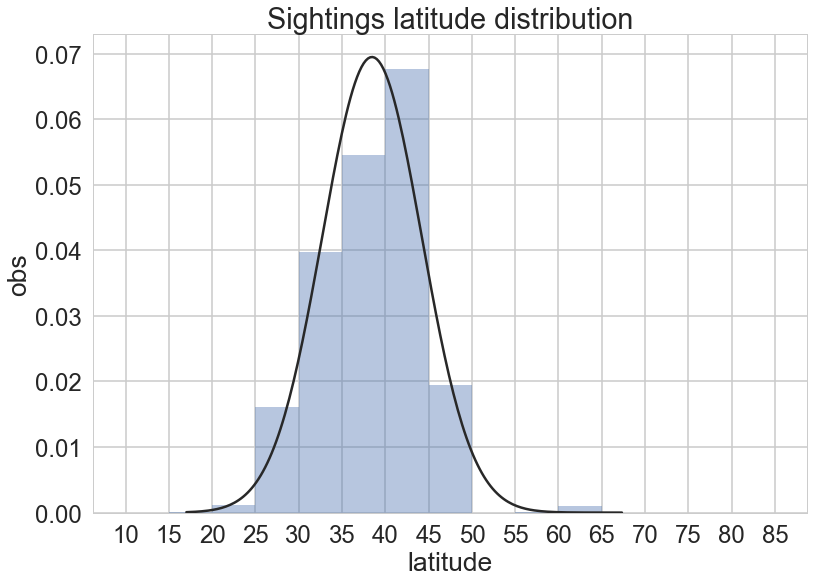

In [53]:
print("Before filtering")
showhist("latitude", "lat", range(10,90,5))

In [54]:
#We seen some outliers
#We must to narrow latitude band of observations due to different climate on outlier's territory

mean = cluster_centers["cluster_lat"].mean()
std = cluster_centers["cluster_lat"].std()
min_lat = mean - 1.65 * std
max_lat = mean + 1.65 * std
c1 = min_lat < selected["cluster_lat"]
c2 = max_lat > selected["cluster_lat"]
selected = selected[c1 & c2]
selected_clusters = pd.DataFrame(selected["cluster"].unique(), columns=["cluster"])
cluster_centers = pd.merge(cluster_centers, selected_clusters, how="inner", on="cluster")


After filtering


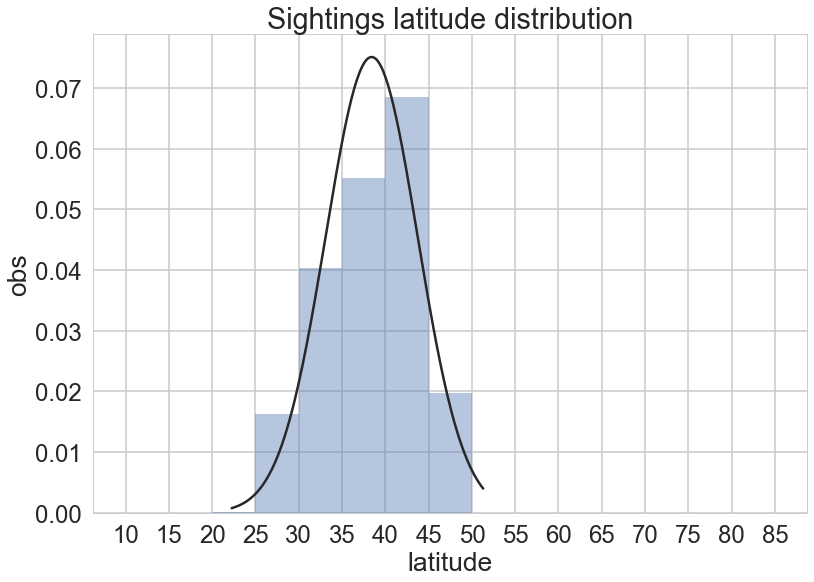

In [55]:
print("After filtering")
showhist("latitude", "lat", range(10,90,5))

In [56]:
# Now find closests weather station for each sighting

def find_closest_station(lat, long):
    
    #speedup optimization
    c1 = ws["Lat"] < (lat + 2)
    c2 = ws["Lat"] > (lat - 2)
    c3 = ws["Long"] > (long - 2)
    c4 = ws["Long"] < (long + 2)
    partial = ws[c1 & c2 & c3 & c4]                           
    if len(partial)>0:
        return partial.apply(lambda x: (math.pow(lat - x["Lat"], 2) + math.pow(long - x["Long"],2)), axis=1).idxmin()
    else:
        return ws.apply(lambda x: (math.pow(lat - x["Lat"], 2) + math.pow(long - x["Long"],2)), axis=1).idxmin()

selected["closest_station"]=selected.apply(lambda x: (find_closest_station( x["lat"], x["long"])), axis=1)
selected.head()

,dt,shape,comments,lat,long,cluster,cluster_lat,cluster_long,distance,closest_city,closest_station
0,2010-10-10 01:00:00,light,Xmas colored rotating lights. ((NUFORC Note: ...,42.767500,-78.744167,11,42.652549,-72.966838,472649.610466,Cheektowaga,USC00301625
1,2010-10-10 17:10:00,light,Saw a light in the sky fading in and out over ...,41.166944,-73.205278,11,42.652549,-72.966838,166552.028876,Bridgeport,USW00094702
2,2010-10-10 20:20:00,fireball,Bus sized fireball object over 91 about 3-400 ...,41.852500,-72.644167,11,42.652549,-72.966838,92944.656239,East Hartford,USW00014740
3,2010-10-10 21:30:00,circle,Circle of light SUNY Albany.,42.652500,-73.756667,11,42.652549,-72.966838,64665.292303,Albany,USW00014735
4,2011-10-10 10:30:00,circle,Amber object in night sky during full moon&#44...,42.096389,-79.375833,11,42.652549,-72.966838,530554.932607,Erie,USC00361362


In [57]:
true = pd.Series([True for x in range(0, selected.shape[0])], name="UFO")

#Key of UFO data is closest weather station and date of sighting

keys = pd.Series(selected["closest_station"]+selected["dt"].dt.strftime("%Y%m%d"), name="key")
ufo = pd.concat([keys, true], axis=1)
ufo.drop_duplicates()
ufo.head()


,key,UFO
0,USC0030162520101010,True
1,USW0009470220101010,True
2,USW0001474020101010,True
3,USW0001473520101010,True
4,USC0036136220111010,True


In [58]:
#read and concatenate datasets for 5 years
wdp  = [(pd.read_csv("wdp201{0}.csv".format(n)).loc[:,["key", "TMIN", "TMAX", "PRCP", "SNOW"]]) for n in range(0,5)]
weather = pd.DataFrame(pd.concat(wdp, axis=0))

#Rename columns to readable
weather.columns=["key", "T day min", "T day max", "Precipitations", "Snowfall"]
weather["T range"] = weather["T day max"] - weather["T day min"]
weather.dropna(how="any", axis=0, inplace=True)

#Merge with UFO sightings data by key.
toclassify = pd.merge(weather, ufo, how="left", on="key")

#Fill empty UFO with False (no sighting) for days/stations with no sightings
toclassify["UFO"].fillna(axis=0, value=False, inplace=True)

#Balance selection. Reduce no-sightings data to size equal of sighting data
reduceData = toclassify[toclassify["UFO"]==False]
todelete = reduceData.sample(n=reduceData.shape[0]-ufo.shape[0])["key"]
toclassify = toclassify[~toclassify['key'].isin(todelete)]

#Now we have dataset with weather parameters. Half of dataset with UFO sighting and half - same stations but no sighting

In [59]:
toclassify.describe().T

,count,mean,std,min,25%,50%,75%,max
T day min,22445.0,52.332591,111.091576,-528.0,-22.0,56.0,139.0,350.0
T day max,22445.0,180.212341,121.078756,-456.0,89.0,200.0,278.0,506.0
Precipitations,22445.0,21.402183,74.919613,0.0,0.0,0.0,3.0,2080.0
Snowfall,22445.0,2.549833,17.036548,0.0,0.0,0.0,0.0,559.0
T range,22445.0,127.879751,51.560586,-155.0,89.0,127.0,161.0,339.0


### Step 3. Data analysis

In [60]:
#Select required variables
y = toclassify["UFO"].copy()
common_features = ["T day min", "T day max", "Precipitations", "Snowfall", "T range"]
x = toclassify[common_features].copy()

#Split data to train and test parts
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

In [61]:
#Use decision tree classification to find difference between UFO-sighting and no-UFO-sighting days
UFO_classifier = DecisionTreeClassifier(max_depth=5)
UFO_classifier.fit(x_train, y_train)

predictions = UFO_classifier.predict(x_test)
pred = pd.Series(predictions, name="prediction")


#calculate prediction rate of UFO==true cases
correct = 0
for a in range(0, len(predictions)):
    if (predictions[a] & y_test.values[a]):
        correct+=1
        
print ("Correct predictions of UFO sighting: "
       +str(round(correct / ufo.shape[0] * 100, 2)) +" %, tree depth="+str(UFO_classifier.tree_.max_depth))

Correct predictions of UFO sighting: 1.94 %, tree depth=5


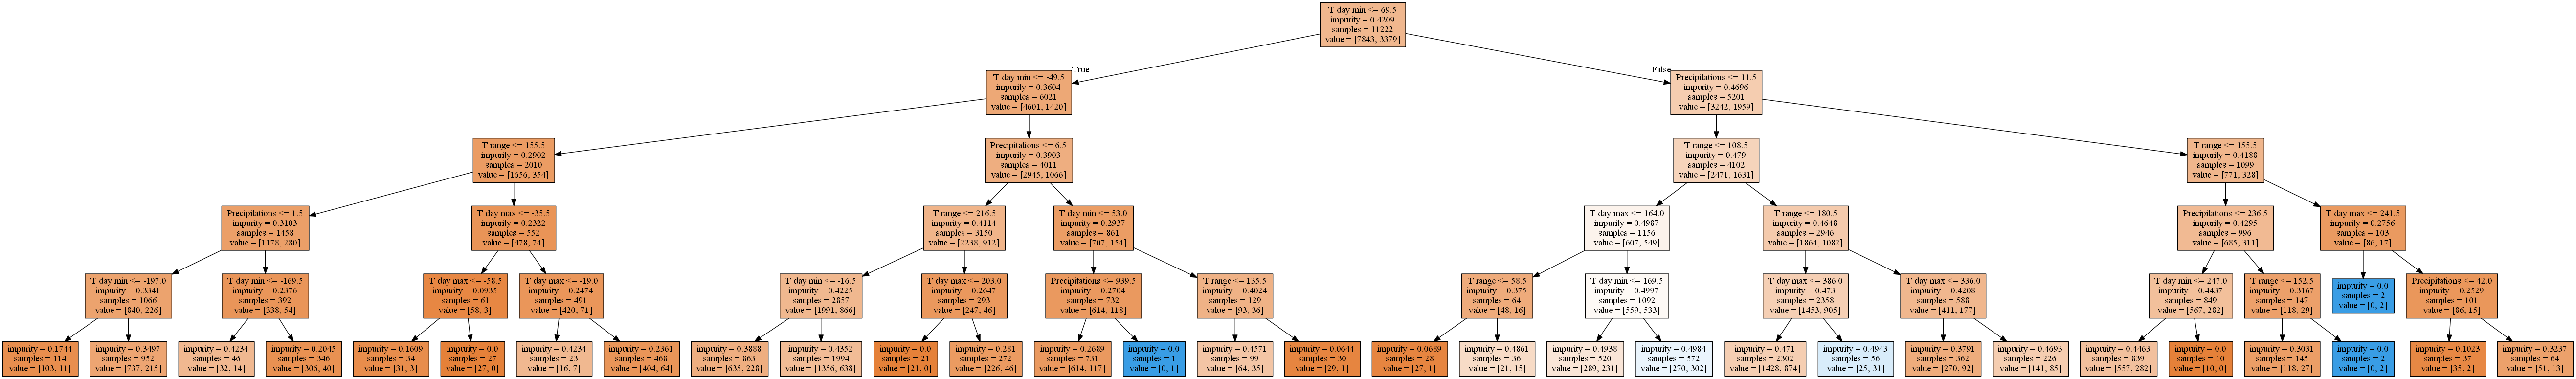

In [62]:
#Show tree with graphviz
sklearn.tree.export_graphviz(UFO_classifier.tree_, out_file='tree.dot', feature_names=x_train.columns, filled=True)
from subprocess import call
call(['dot', '-T', 'png', 'tree.dot', '-o', 'tree.png'])
Image("tree.png")


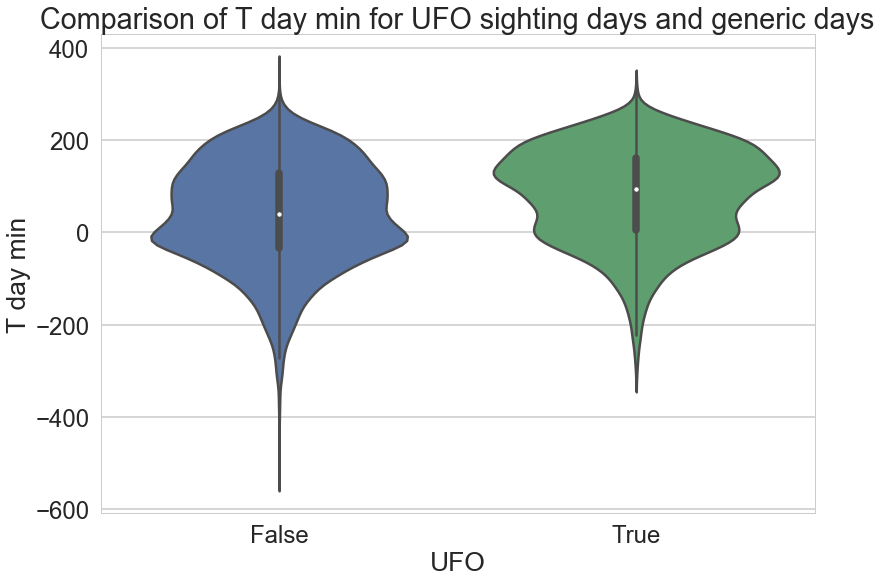

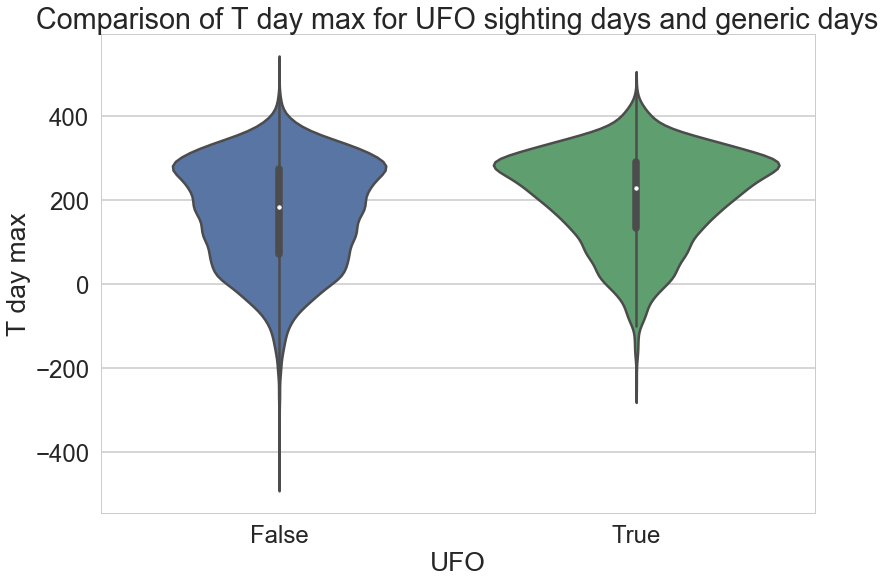

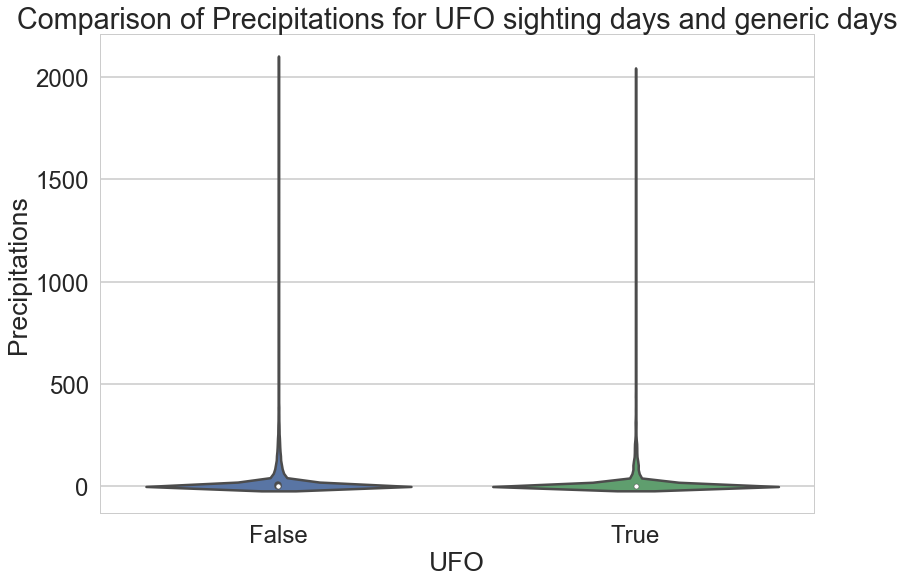

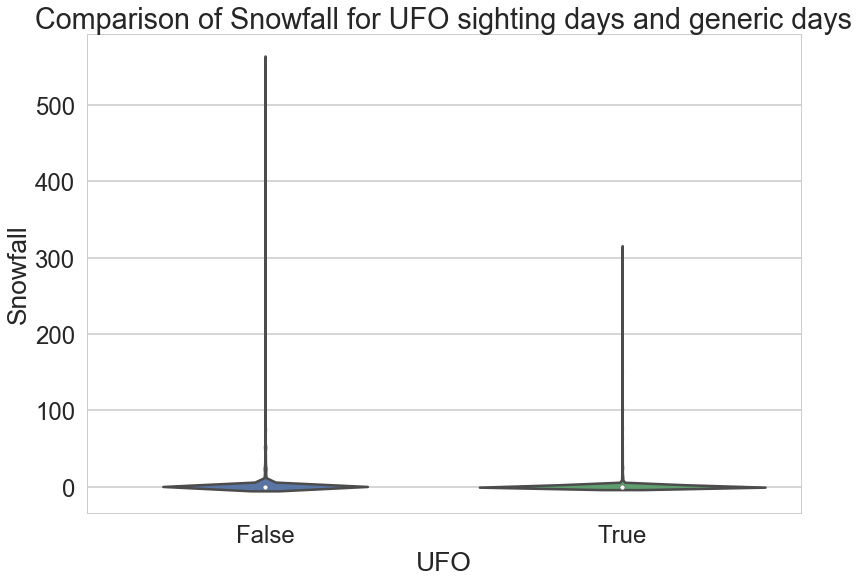

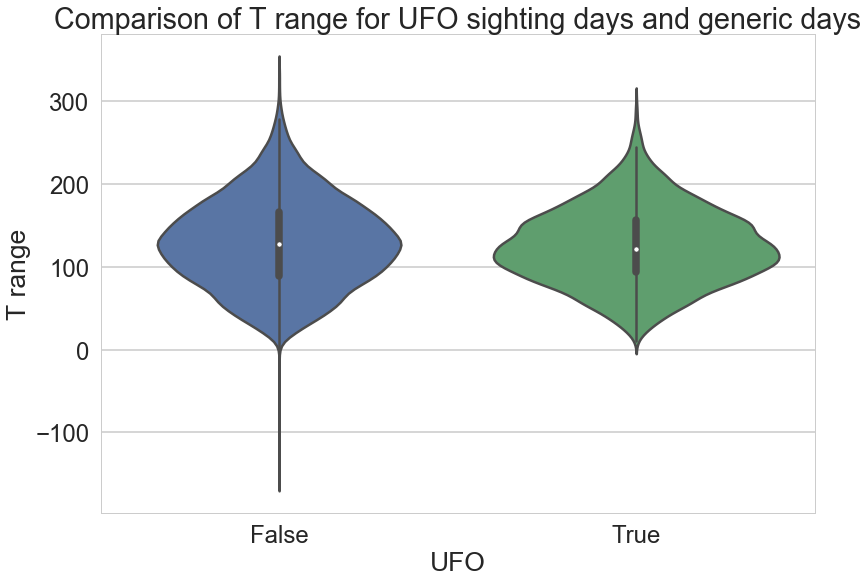

In [63]:
#Now compare two groups (UFO-sighting and no-UFO-sighting) by each parameter
def showviolinplot(parameter):
    sns.violinplot(data=toclassify, x="UFO", y=parameter)
    plt.ylabel(parameter)
    plt.title("Comparison of "+parameter+" for UFO sighting days and generic days")
    plt.show()

[showviolinplot(c) for c in toclassify.columns[1:6]];



In [ ]:
#We find that UFO=true group has higher temperatures

## Conclusions

-  UFO sightings can be clustered around 15 cities
-  Found cities with very high sighting rate (about 1 per week)
-  UFO sighting can not be predicted by generic weather parameters
-  UFO sighting often occurs in warm days
-  Deeper analysis requires more resources than available
